In [5]:
!pip install tensorflow-datasets

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached importlib_resources-6.4.5-py3-none-any.whl.metadata (4.0 kB)
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ----------------- ---------------------- 2.4/5.3 MB 11.2 MB/s eta 0:00:01
   ----------------------- ---------------- 3.1/5.3 MB 8.4 MB/s eta 0:00:01
   --------------------------------- ------ 4.5/5.3 MB 7.2 MB/s eta 0:00:01
   ---------------------------------------- 5.3/5.3 MB 6.2 MB/s eta 0:00:00
Using cached importlib_resources-6.4.5-py3-none-any.whl (36 kB)
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21544 sha256=a84f4cbcc1748867e2d3fc73b8cb47122a3dd57512264db809c6436fc7f4b101
  Stored in directory: c:\users\dilfina\appdata\local\pip\cache\wheels\e7\e6\28\864bdfee5339dbd6ddcb5a186286a8e217648ec198bdf0097d
Successfully built promise



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Dilfina\tensorflow_datasets\horses_or_humans\incomplete.C9OS94_3.0.0\horses_or_humans-train…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Dilfina\tensorflow_datasets\horses_or_humans\incomplete.C9OS94_3.0.0\horses_or_humans-test.…

Dataset horses_or_humans downloaded and prepared to C:\Users\Dilfina\tensorflow_datasets\horses_or_humans\3.0.0. Subsequent calls will reuse this data.
Number of training images: 1027
Number of testing images: 256
Epoch 1/5


c:\Users\Dilfina\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.7294 - loss: 0.4846 - val_accuracy: 0.8438 - val_loss: 1.3194
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.9666 - loss: 0.0999 - val_accuracy: 0.8320 - val_loss: 2.1352
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 220ms/step - accuracy: 0.9756 - loss: 0.0603 - val_accuracy: 0.8086 - val_loss: 2.8593
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.9720 - loss: 0.0598 - val_accuracy: 0.8750 - val_loss: 1.2750
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.9941 - loss: 0.0152 - val_accuracy: 0.8828 - val_loss: 1.2428
Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.5906 - loss: 0.6548 - val_accuracy: 0.7305 - val_loss: 0.5684
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.8161 - loss: 0.4188 - val_accuracy: 0.6562 - val_loss: 1.5747
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.9076 - loss: 0.2513 - val_accuracy: 0.7305 - val_loss: 1

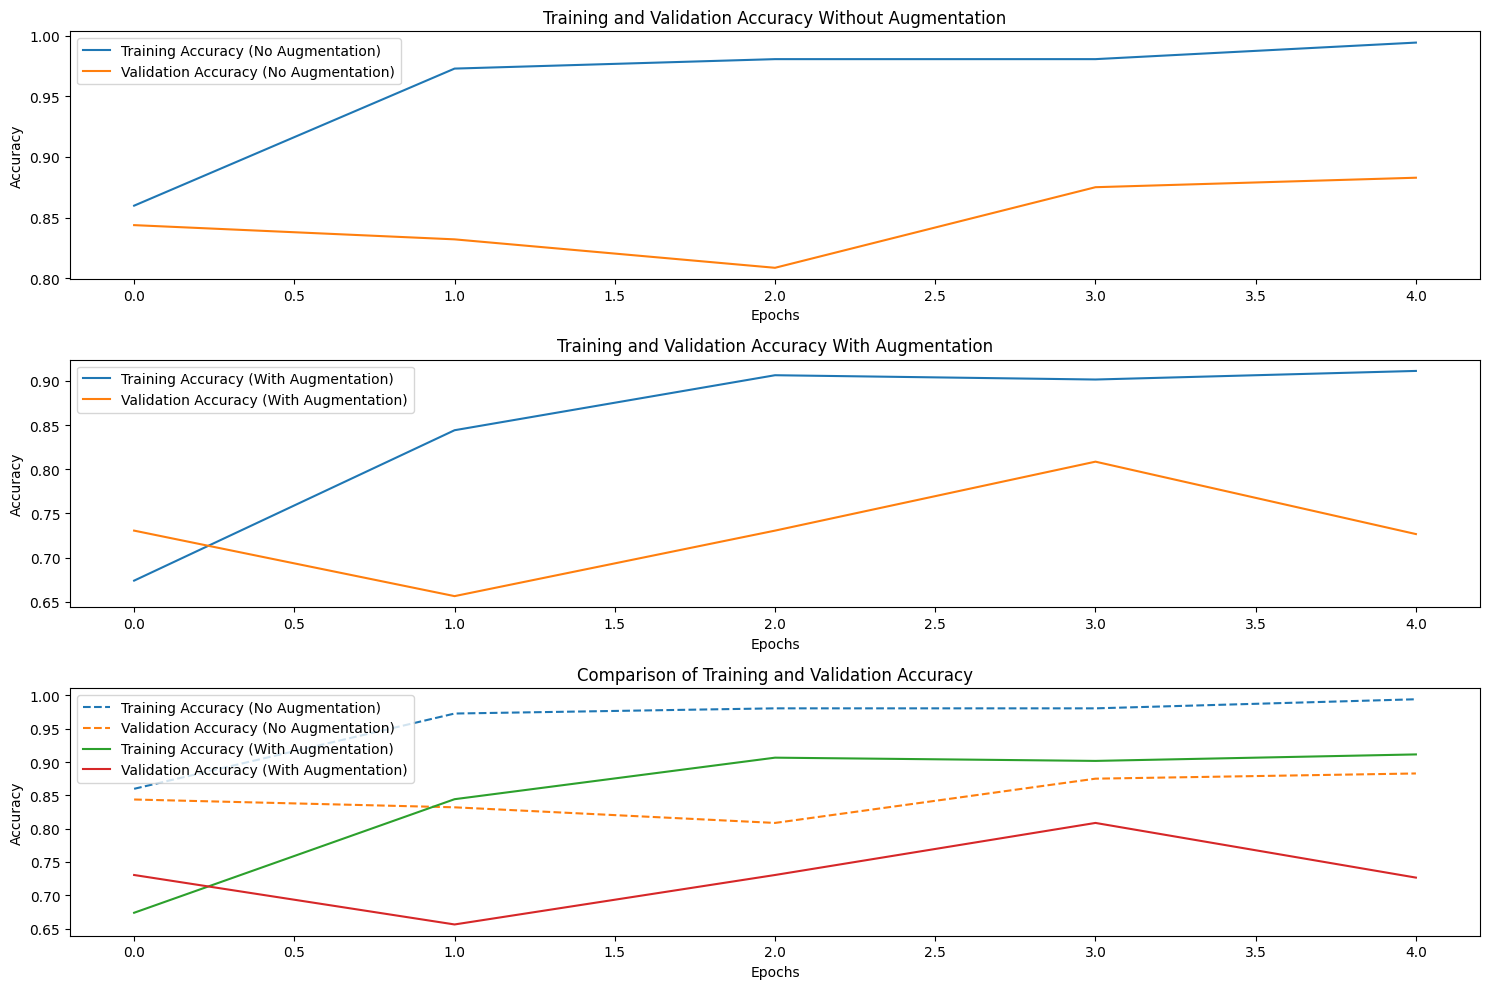

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# a) Load the dataset
(ds_train, ds_test), ds_info = tfds.load('horses_or_humans', split=['train', 'test'], with_info=True, as_supervised=True)

# b) Show the number of training and testing images
train_size = ds_info.splits['train'].num_examples
test_size = ds_info.splits['test'].num_examples
print(f"Number of training images: {train_size}")
print(f"Number of testing images: {test_size}")

# c) Define image augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2)
])

# Prepare dataset with and without augmentation
def prepare(ds, batch_size=32, augment=False):
    ds = ds.map(lambda x, y: (tf.image.resize(x, (128, 128)), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(tf.data.AUTOTUNE)

train_ds = prepare(ds_train, augment=False)
train_ds_augmented = prepare(ds_train, augment=True)
test_ds = prepare(ds_test)

# d) Build CNN model
def create_cnn_model():
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=(128, 128, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Instantiate models
model_no_aug = create_cnn_model()
model_aug = create_cnn_model()

# e) Train model without augmentation
history_no_aug = model_no_aug.fit(train_ds, epochs=5, validation_data=test_ds)

# f) Train model with augmentation
history_aug = model_aug.fit(train_ds_augmented, epochs=5, validation_data=test_ds)

# g) Plotting results
plt.figure(figsize=(15, 10))

# 1. Plot accuracy for training without augmentation
plt.subplot(3, 1, 1)
plt.plot(history_no_aug.history['accuracy'], label='Training Accuracy (No Augmentation)')
plt.plot(history_no_aug.history['val_accuracy'], label='Validation Accuracy (No Augmentation)')
plt.title("Training and Validation Accuracy Without Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# 2. Plot accuracy for training with augmentation
plt.subplot(3, 1, 2)
plt.plot(history_aug.history['accuracy'], label='Training Accuracy (With Augmentation)')
plt.plot(history_aug.history['val_accuracy'], label='Validation Accuracy (With Augmentation)')
plt.title("Training and Validation Accuracy With Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# 3. Plot comparison of both training approaches
plt.subplot(3, 1, 3)
plt.plot(history_no_aug.history['accuracy'], label='Training Accuracy (No Augmentation)', linestyle='--')
plt.plot(history_no_aug.history['val_accuracy'], label='Validation Accuracy (No Augmentation)', linestyle='--')
plt.plot(history_aug.history['accuracy'], label='Training Accuracy (With Augmentation)')
plt.plot(history_aug.history['val_accuracy'], label='Validation Accuracy (With Augmentation)')
plt.title("Comparison of Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [1]:
!pip install tensorflow-datasets


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Number of training images: 1027
Number of testing images: 256
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 106s 5s/step - accuracy: 0.8569 - loss: 0.2495 - val_accuracy: 0.5000 - val_loss: 22.3603
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.9977 - loss: 0.0084 - val_accuracy: 0.5000 - val_loss: 31.9546
Training Accuracy: 99.81%
Validation Accuracy: 50.00%


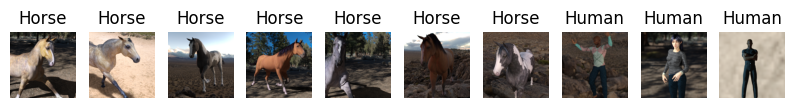

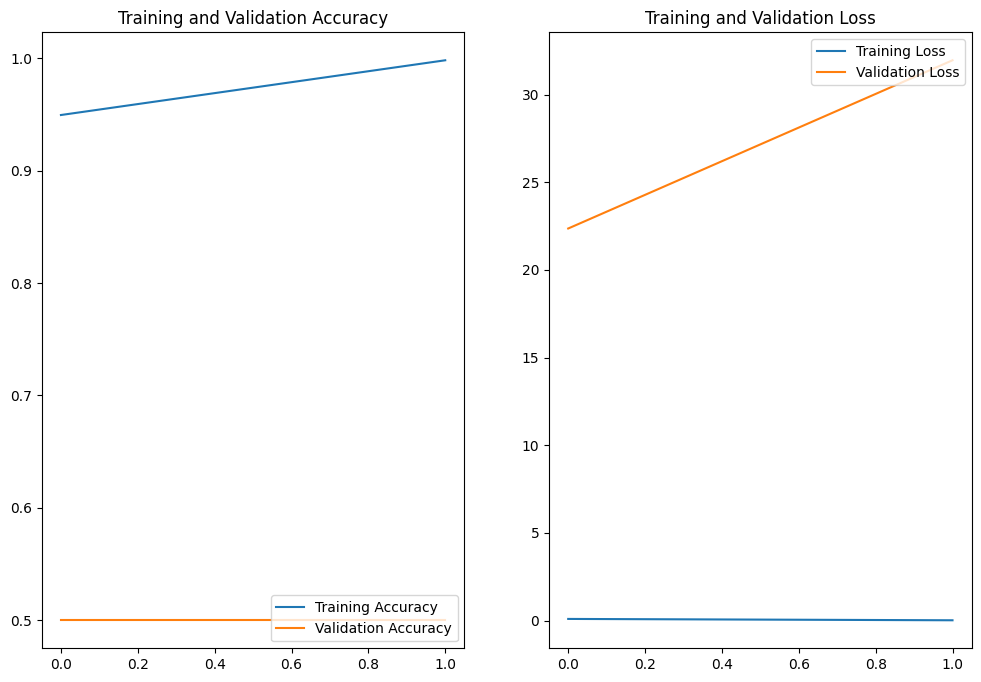

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset (Horses or Humans)
train_ds, test_ds = tfds.load('horses_or_humans', split=['train', 'test'], as_supervised=True)

# Step 1: Show number of images in train and test datasets
num_train = tf.data.experimental.cardinality(train_ds).numpy()
num_test = tf.data.experimental.cardinality(test_ds).numpy()
print(f"Number of training images: {num_train}")
print(f"Number of testing images: {num_test}")

# Step 2: Plot some images
def plot_samples(dataset, num_samples=10):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_samples)):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title("Human" if label == 1 else "Horse")
        plt.axis("off")

plot_samples(train_ds)

# Step 3 (Updated): Image Augmentation (contrast, flipping, rotation, and resizing)
def augment(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize to match MobileNetV2 input size
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0.2, 0.5)
    image = tf.image.rot90(image)
    return image, label

augmented_train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda image, label: (tf.image.resize(image, (224, 224)), label), 
                      num_parallel_calls=tf.data.AUTOTUNE)


# Step 4: Normalizing the images
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # normalize to [0,1]
    return image, label

augmented_train_ds = augmented_train_ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

# Step 5: Prepare datasets for training
batch_size = 64
augmented_train_ds = augmented_train_ds.cache().shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Step 6: Define a simple Faster R-CNN model (using a pre-trained base)
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights="imagenet")

# Faster R-CNN specific layers
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Step 7: Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 8: Train the model
epochs = 2
history = model.fit(augmented_train_ds, validation_data=test_ds, epochs=epochs)

# Step 9: Show training and testing accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Plot accuracy and loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)
